In [2]:
import pandas as pd
pd.set_option('display.max_columns', None)
pd.set_option('display.max_colwidth', None)   
pd.set_option('display.max_rows', None)
pd.set_option('display.float_format', lambda x: '%.5f' % x)
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn import preprocessing

In [3]:
with open("data/Data_120294_2023-03-29.csv", "r") as f:
    d = pd.read_csv(f)

d.head()

/tmp/ipykernel_55987/2003393883.py:2: DtypeWarning: Columns (2,64,91,94,97,106,108,109,110,111,112,114,116,119,120,122,127,139,142,143,144,145,152,153,154,155,156,157,159,160,161,163,164,165,169,170,171,172,175,178,179,180,187,189,215,216,217,218,219,317,318) have mixed types. Specify dtype option on import or set low_memory=False.
  d = pd.read_csv(f)


,wl_org,cod_wl,cod_ostxt_wl,num_prev_tx,thoracic_dgn,tah,vas,onvent,icu,inotropic,gender,abo,wgt_kg_tcr,hgt_cm_tcr,bmi_tcr,education,ecmo_tcr,iabp_tcr,inhaled_no,inotropes_tcr,vad_device_ty_tcr,vad_brand1_tcr,vad_brand2_tcr,vad_tah_tcr,func_stat_tcr,tcr_dgn,diab,dial_ty_tcr,cereb_vasc,malig_tcr,malig_ty_tcr,most_rcnt_creat,tot_serum_album,sud_death,impl_defibril,hemo_sys_tcr,hemo_pa_dia_tcr,hemo_pa_mn_tcr,hemo_pcw_tcr,hemo_co_tcr,cig_use,tcr_dur_abstain,prior_card_surg_tcr,histry_cig_old,sternotomy_tcr,ssdmf_death_date,days_stat1,days_stat1a,days_stat2,days_stat1b,days_stata4,days_stata5,days_stata2,days_stata3,days_stata1,days_stata6,init_stat,init_creat,rem_cd,dayswait_chron,end_stat,init_age,life_sup_tcr,activate_date,death_date,end_date,init_date,ethnicity,ethcat,pt_code,init_hgt_cm_calc,init_wgt_kg_calc,init_bmi_calc,end_hgt_cm_calc,end_wgt_kg_calc,end_bmi_calc,composite_death_date,ventilator_tcr,lvad_at_listing,lvad_while_listed,rvad_at_listing,rvad_while_listed,work_income_tcr,academic_prg_tcr,academic_level_tcr,exercise_o2,academic_level_trr,academic_prg_trr,func_stat_trr,med_cond_trr,ecmo_trr,work_income_trr,cognitive_dev_trr,motor_dev_trr,measurement_date_trr,pge_trr,creat_trr,dial_after_list,fev1_trr,fvc_trr,hemo_co_trr,hemo_pa_dia_trr,hemo_pa_mn_trr,hemo_pcw_trr,hemo_sys_trr,iabp_trr,infect_iv_drug_trr,inotropes_trr,inotrop_vaso_co_trr,inotrop_vaso_dia_trr,inotrop_vaso_mn_trr,inotrop_vaso_pcw_trr,inotrop_vaso_sys_trr,pco2_trr,steroid,tbili,transfusions,vad_device_ty_trr,prior_card_surg_type_trr,prior_card_surg_type_ostxt_trr,cmv_status,cod,cod_ostxt,gstatus,gtime,lastfuno,ptime,px_stat,func_stat_trf,amis,bmis,drmis,hlamis,pramr,prapk,pramr_cl1,pramr_cl2,prapk_cl1,prapk_cl2,hist_cocaine_don,age_don,ethcat_don,abo_don,alcohol_heavy_don,gender_don,cod_ostxt_don,bun_don,creat_don,sgot_don,sgpt_don,tbili_don,hypertens_dur_don,cancer_oth_ostxt_don,contin_cig_don,contin_cocaine_don,contin_oth_drug_don,diet_don,diuretics_don,diabdur_don,hist_hypertens_don,hist_cancer_don,hist_insulin_dep_don,hist_diabetes_don,diabetes_don,hist_oth_drug_don,insulin_don,hgt_cm_don_calc,wgt_kg_don_calc,bmi_don_calc,px_stat_date,tx_date,discharge_date,tx_type,abo_mat,age,dial_prior_tx,ischtime,grf_fail_cause,grf_fail_date,grf_stat,age_group,hgt_cm_calc,wgt_kg_calc,bmi_calc,distance,vad_tah_trr,tx_year,referral_date,pco2_don,pulm_cath_don,map_init_don,map_post_don,cvp_cath_init_don,cvp_cath_post_don,cvp_cath_old_don,pcwp_init_don,pcwp_post_don,svr_init_don,svr_post_don,syst_pa_cath_init_don,syst_pa_cath_post_don,systolic_pa_cath_old_don,diast_pa_cath_init_don,diast_pa_cath_post_don,diastolic_pa_cath_old_don,cardiac_output_cath_init_don,cardiac_output_cath_post_don,cardiac_output_cath_old_don,card_idx_init_don,card_idx_post_don,broncho_lt_don,broncho_rt_don,chest_xray_don,ph_don,hematocrit_don,abn_valves_don,abn_lvh_don,abn_congen_don,wall_abn_seg_don,wall_abn_glob_don,data_transplant,data_waitlist,alg_ind,alg_maint,cyclosporin_ind,cyclosporin_maint,okt4_ind,okt4_maint,cytoxan_ind,cytoxan_maint,methotrexate_ind,methotrexate_maint,brequinarsodium_ind,brequinarsodium_maint,mizoribine_ind,mizoribine_maint,atgam_ind,atgam_maint,nratgnrats_ind,nratgnrats_maint,okt3_ind,okt3_maint,xomazymecd5_ind,xomazymecd5_maint,dab486il2_ind,dab486il2_maint,antilfa1_ind,antilfa1_maint,antiicam1_ind,antiicam1_maint,il1receptorantagonist_ind,il1receptorantagonist_maint,antiil6_ind,antiil6_maint,antitnf_ind,antitnf_maint,solubleil1receptor_ind,solubleil1receptor_maint,aldesleukin_ind,aldesleukin_maint,t10b9_ind,t10b9_maint,sandimmune_ind,sandimmune_maint,deoxyspergualin_ind,deoxyspergualin_maint,neoral_ind,neoral_maint,sangcya_ind,sangcya_maint,thymoglobulin_ind,thymoglobulin_maint,zenapax_ind,zenapax_maint,simulect_ind,simulect_maint,gengraf_ind,gengraf_maint,zortress_ind,zortress_maint,eon_ind,eon_maint,myfortic_ind,myfortic_maint,genericcyclosporin_ind,genericcyclosporin_maint,steroids_ind,steroids_maint,prograf_ind,prograf_maint,campath_ind,campath_maint,fty720_in

# Column categorization

In [4]:
print(d.education.dtype)
print(d.education.unique())

float64
[ nan   6.   5.   4.   3.   2. 996. 998.   1.]


There seems to exists columns that appear numeric but are actually categoric. We need to categorize all columns into numeric or categoric values in able to normalize and impute values properly.

In the provided documentation XLS file, numeric columns do not have a "SAS ANALYSIS FORMAT". The "SAS FORMAT" columns also gives information about how the data is formatted. Specially, some data is formatted as dates and datetimes, and need to be handled separately. Let's use this information to categorize the columns.

In [5]:
# fetch data from excel file
with open("data/Documentation.xls", "rb") as f:
    docs = pd.read_excel(f, sheet_name=None, header=None)
docs[list(docs.keys())[0]].head()

,0,1,2
0,Worksheet Tab Name,Description of Contents,Relative File (s)
1,File Formats,Explanation of the data file formats within folders provided on the disc,ALL
2,MAIN DOCUMENTATION,Descriptions for individual files with hyperlinks to data field documentation,ALL
3,Formats (Lookup Values),Provides locations for SAS formats and lookup values for variables,ALL
4,Additional HLA,Data dictionary for HLA data (all organ types),All Organs


In [6]:
def is_data_sheet(docs, sheet):
    if "SAS ANALYSIS FORMAT" in docs[sheet].values[1] \
    and "FORMAT".lower() not in sheet.lower():
        return True
    return False

def find_column_index(docs, sheet, column_name):
    return list(docs[sheet].values[1]).index(column_name)

discovered_columns = set()
numerical_columns = set()
categorical_columns = set()
date_columns = set()
text_columns = set()
drug_columns = set()
unknown_type_columns = set()

for sheet in docs:
    if is_data_sheet(docs, sheet):
        sas_index = find_column_index(docs, sheet, "SAS ANALYSIS FORMAT")
        format_index = find_column_index(docs, sheet, "SAS FORMAT")
        type_index = find_column_index(docs, sheet, "DATA TYPE")

        for row in docs[sheet].values[2:]:
            cname = row[0].lower()
            if cname not in discovered_columns:
                discovered_columns.add(cname)

                csas = str(row[sas_index]).upper()
                ctype = str(row[type_index]).upper()
                cformat = str(row[format_index]).upper()

                if "ostxt" in cname:
                    text_columns.add(cname)
                elif cname.endswith("_ind") or cname.endswith("_maint"):
                    drug_columns.add(cname)
                elif ctype == "NUM":
                    if "MMDDYY" in cformat or "MMDDYY" in csas:
                        date_columns.add(cname)
                    elif csas == "NAN":
                        numerical_columns.add(cname)
                    else:
                        categorical_columns.add(cname)
                elif ctype == "CHAR":
                    categorical_columns.add(cname)
                elif ctype == "DATE":
                    date_columns.add(cname)
                else:
                    unknown_type_columns.add(cname)


print("Numerical columns:", numerical_columns)
print("Categorical columns:", categorical_columns)
print("Date columns", date_columns)
print("String columns:", text_columns)
print("Unknown type columns:", unknown_type_columns)

Numerical columns: {'init_priority', 'pco2_don', 'ecmowithouthemosbpdt', 'cold_isch', 'req_low_inotrope', 'extcardiacindexdt', 'met_liver_donor', 'predon_wgt', 'days_stata2', 'hrsevfailsodium', 'calc_bmi', 'doncrit_min_wgt_import', 'malig_don_rel_6_dx_date', 'brain_death_time', 'req5_circulatory_device', 'mcsdplasmafreehemoglobin', 'rvad_at_listing', 'card_idx_init_don', 'cpr_admin_duration', 'iabpwithouthemoast', 'max_iexpanded_mismatch_dr', 'sendatamfithresholdst', 'case_id', 'distance', 'currthertorsemide', 'covid19_antibody_specdt', 'on_vent_trr', 'sodium170_val_don', 'malig_denovo_tumor_2_dx_date', 'malig_denovo_tumor_25_dx_date', 'inomuldopamine', 'low_pco2_o2_test', 'malig_don_rel_11_dx_date', 'skin_melanoma_donor', 'septal_wall', 'svr_init_don', 'width_aortic_knob', 'malig_denovo_tumor_14_dx_date', 'systolic_pa_cath_old_don', 'hemo_pcw_trr', 'malig_don_rel_26_dx_date', 'vent_timeframe_trr', 'reop_hernia_ki', 'lipase_don', 'inosinmilrinone', 'init_inr', 'ino_procure_dose_3', 'va

Let's investigate the columns with unknown type.

In [7]:
for column in unknown_type_columns:
    if column in d.columns:
        print(column, d[column].dtype, d[column].unique())

None of these columns are in the dataset, so we are going to ignore them.

Let's explore how well the documentation describes the data set.

In [8]:

col_union = set.union(numerical_columns, categorical_columns, date_columns, text_columns, unknown_type_columns)
print("Number columns in the documentation:", len(col_union))

print("Number columns in dataset:", len(d.columns))

intersect = col_union & set(d.columns)
print("Number shared columns:", len(intersect))

# check which columns are not described in the documentation
non_described_columns = set(d.columns) - intersect
print("Number undocumented:", len(non_described_columns))
print("Undocumented columns:", non_described_columns)


Number columns in the documentation: 2763
Number columns in dataset: 320
Number shared columns: 222
Number undocumented: 98
Undocumented columns: {'alg_ind', 'zenapax_ind', 'imuran_ind', 'genericsirolimus_maint', 'mizoribine_maint', 'campath_ind', 'genericsirolimus_ind', 'atgam_ind', 'zortress_ind', 'antitnf_maint', 'myfortic_ind', 'antitnf_ind', 'astagrafxl_maint', 'antiil6_maint', 'methotrexate_ind', 'brequinarsodium_maint', 'myfortic_maint', 'neoral_ind', 'envarsusxr_ind', 'generictacrolimus_maint', 'simulect_ind', 'il1receptorantagonist_ind', 'nulojix_maint', 'genericmyfortic_ind', 'imuran_maint', 'deoxyspergualin_ind', 'antiil6_ind', 'nratgnrats_ind', 'fty720_maint', 'il1receptorantagonist_maint', 'oth_drug_ostxt1', 'okt3_ind', 'okt4_ind', 'solubleil1receptor_ind', 'methotrexate_maint', 'aldesleukin_maint', 'genericmyfortic_maint', 'dab486il2_ind', 'rapamune_ind', 'cellcept_maint', 'cyclosporin_ind', 'leflunomide_maint', 'envarsusxr_maint', 'steroids_ind', 'campath_maint', 'sandim

Let's investigate the types of these columns.

In [9]:
for col in non_described_columns:
    # print unique values and counts of each column
    print(d[col].value_counts())

0.00000    20
1.00000    19
Name: alg_ind, dtype: int64
1.00000    3048
0.00000     209
Name: zenapax_ind, dtype: int64
1.00000    13158
0.00000     6439
Name: imuran_ind, dtype: int64
1.00000    11
0.00000     1
Name: genericsirolimus_maint, dtype: int64
0.00000    9
Name: mizoribine_maint, dtype: int64
1.00000    500
0.00000      2
Name: campath_ind, dtype: int64
0.00000    11
1.00000     1
Name: genericsirolimus_ind, dtype: int64
1.00000    4856
0.00000     416
Name: atgam_ind, dtype: int64
0.00000    235
1.00000     36
Name: zortress_ind, dtype: int64
0.00000    7
Name: antitnf_maint, dtype: int64
0.00000    2028
1.00000       1
Name: myfortic_ind, dtype: int64
0.00000    7
Name: antitnf_ind, dtype: int64
1.00000    148
Name: astagrafxl_maint, dtype: int64
0.00000    9
Name: antiil6_maint, dtype: int64
0.00000    130
1.00000     66
Name: methotrexate_ind, dtype: int64
0.00000    9
Name: brequinarsodium_maint, dtype: int64
1.00000    2027
0.00000       2
Name: myfortic_maint, dtype:

Most of these columns are drug related or categorical. Let's categorize these similarly to before.

In [10]:
for col in non_described_columns:
    if col.endswith("_ind") or col.endswith("_maint"):
        drug_columns.add(col)
    elif "ostxt" in col:
        text_columns.add(col)
    else:
        categorical_columns.add(col)
unknown_type_columns = []

Let's investigate if any categoric columns have too many unique values.

In [11]:
# sort columns by number of unique values
categoric_sorted_unique = d[list(categorical_columns & set(d.columns))].nunique().sort_values(ascending=False)
print(categoric_sorted_unique)

cod                         76
cod_wl                      63
malig_ty_tcr                56
thoracic_dgn                56
tcr_dgn                     42
prior_card_surg_type_trr    27
func_stat_trr               25
func_stat_trf               25
func_stat_tcr               25
rem_cd                      18
init_stat                   11
end_stat                    11
abo_don                      9
tcr_dur_abstain              9
abo                          9
vad_tah_trr                  8
education                    8
broncho_lt_don               8
ethcat                       8
broncho_rt_don               8
vad_tah_tcr                  8
ethcat_don                   8
chest_xray_don               7
hist_diabetes_don            6
academic_level_trr           6
vad_device_ty_trr            6
vad_device_ty_tcr            6
diab                         6
cognitive_dev_trr            5
academic_prg_trr             5
motor_dev_trr                5
dial_ty_tcr                  5
academic

Let's similarly investigate if any numeric columns have too few unique values.

In [12]:
numeric_sorted_unique = d[list(numerical_columns & set(d.columns))].nunique().sort_values(ascending=True)
print(numeric_sorted_unique)

init_creat                           0
lvad_while_listed                    1
rvad_while_listed                    1
pco2_trr                             1
rvad_at_listing                      1
lvad_at_listing                      1
inotropes_trr                        2
inhaled_no                           2
fev1_trr                             2
inotropes_tcr                        2
ventilator_tcr                       2
ecmo_tcr                             2
iabp_trr                             2
iabp_tcr                             2
ecmo_trr                             2
pge_trr                              2
gstatus                              2
fvc_trr                              2
amis                                 3
drmis                                3
bmis                                 3
sternotomy_tcr                       4
exercise_o2                          4
hlamis                               7
num_prev_tx                         10
vad_brand2_tcr           

Consulting with the documentation descriptions, some of these columns were misidentified, and should be categorical.

In [13]:
misidentified_columns = set([
    'init_creat',
    'lvad_at_listing',
    'lvad_while_listed',
    'rvad_at_listing',
    'rvad_while_listed',
    'iabp_tcr',
    'iabp_trr',
    'ecmo_tcr',
    'ecmo_trr',
    'inotropes_tcr',
    'inotropes_trr',
    'inhaled_no',
    'gstatus',
    'pge_trr',
    'ventilator_tcr',
    'amis',
    'bmis',
    'drmis',
    'vad_brand1_tcr',
    'vad_brand2_tcr'
])

#exercise_o2?

categorical_columns = categorical_columns | misidentified_columns
numerical_columns = numerical_columns - misidentified_columns

Let's exclude variables not in the dataset.

In [14]:
numerical_columns = list(numerical_columns & set(d.columns))
categorical_columns = list(categorical_columns & set(d.columns))
date_columns = list(date_columns & set(d.columns))
drug_columns = list(drug_columns & set(d.columns))
text_columns = list(text_columns & set(d.columns))

In [15]:
print("Columns in the dataset:\n")
print("Number numeric columns:", len(numerical_columns))
print("Number categorical columns:", len(categorical_columns))
print("Number date columns:", len(date_columns))
print("Number drug columns:", len(drug_columns))
print("Number text columns:", len(text_columns))

Columns in the dataset:

Number numeric columns: 91
Number categorical columns: 119
Number date columns: 12
Number drug columns: 91
Number text columns: 7


That's all the categorization done.

Let's additionally convert the date columns to comparable timestamps.

In [16]:
for col in date_columns:
    d[col] = pd.to_datetime(d[col], format="%d%b%Y")

# Removal of unwanted data

We want to remove all data of people under the age of 18.

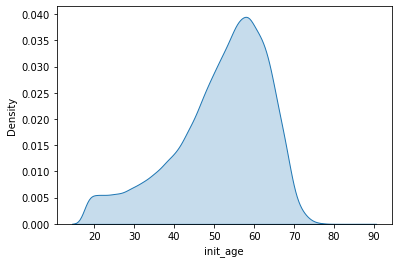

In [17]:
d = d[d.init_age >= 18]

# plot distribution of age
sns.kdeplot(d.init_age, fill=True)
plt.show()

Furthermore, we need to somehow merge entries belonging to the same patient.

One way to handle this is to just drop all rows of patients with more than one record in the waitlist. However, this might be a bit crude if there are many patients with multiple records.

Proportion of patients with more than one record: 0.07628644895324749
0    12314
1     2917
2       84
3       13
Name: num_prev_tx, dtype: int64
0     87734
1       925
2        53
3         8
5         3
6         2
10        2
4         2
9         1
7         1
Name: num_prev_tx, dtype: int64


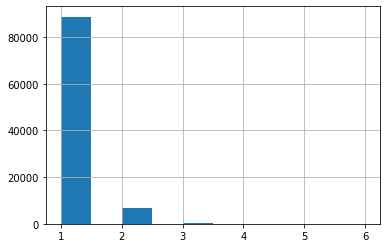

In [18]:
rcount = d.groupby("pt_code").wl_org.count()
rcount.hist()

gt1 = rcount[rcount > 1]

# print proportion of patients with at least 2 records
print("Proportion of patients with more than one record:", len(gt1) / d.pt_code.nunique())

# of those with more than one record, print the value counts for "num_prev_tx"
print(d[d.pt_code.isin(gt1.index)].num_prev_tx.value_counts())
# num_prev_tx for those with only one record
print(d[~d.pt_code.isin(gt1.index)].num_prev_tx.value_counts())

There are a significant amount of patients with multiple records.

A different approach could be to keep the most recent record for each patient, which is what we will try.

In [19]:
d.sort_values(by=['pt_code', 'num_prev_tx', 'init_date'], inplace=True)
d.drop_duplicates(subset=['pt_code', 'num_prev_tx'], keep='last', inplace=True)

There is a large amount of possible outcomes for each patient, detailed in the column rem_cd. Most of these outcomes have barely any patients assigned to them. We will filter the data set to only include the most common outcomes.

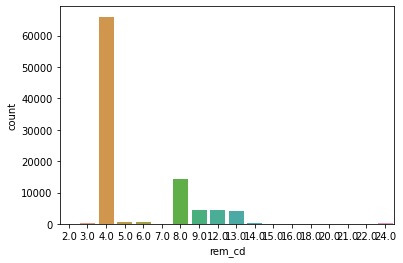

In [20]:
sns.countplot(x="rem_cd", data=d)
plt.show()

Let's remove all outcomes except the most common: [4,8,9,12,13]

In [21]:
d = d[d.rem_cd.isin([4,8,9,12,13])]

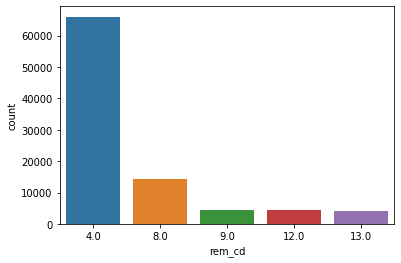

In [22]:
sns.countplot(x="rem_cd", data=d)
plt.show()

# Removal of outliers

Before imputation and normalization, outliers need to be removed.

In [23]:
# replace outliers of numerical columns with NaN
lower = d.quantile(0.0005, numeric_only=True)
upper = d.quantile(0.9995, numeric_only=True)
d2 = d.copy()

d2[numerical_columns] = d2[numerical_columns][(d2[numerical_columns].lt(upper)) & (d2[numerical_columns].gt(lower))]
d, d2 = d2, d

Here's an example of how removing outliers improves the usability of values. This is the distribution plot of the column "bmi_tcr" before and after removing outliers.

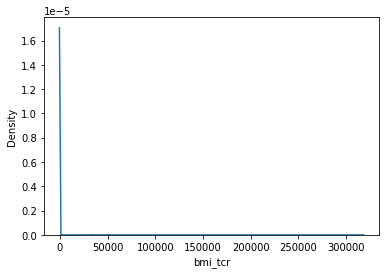

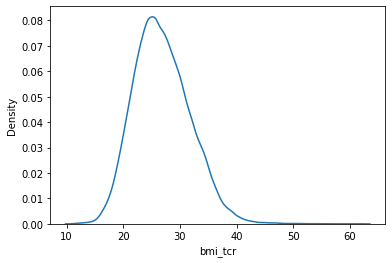

In [24]:
col = "bmi_tcr"

sns.kdeplot(d2[col].dropna())
plt.show()

sns.kdeplot(d[col].dropna())
plt.show()


# Selection of candidate columns

Variables are selected as deemed approprate by one of our supervisors.

In [25]:
sheet = pd.read_excel("data/VariableNames_v3.xlsx", sheet_name="Sheet1")
inclusion = dict(zip(sheet.iloc[:, 0], sheet.iloc[:, 2]))

selected_vars = [var for var in inclusion if inclusion[var] == "X"]
selected_vars.remove("init_creat") # only contains missing values

print("Selected variables:", selected_vars)
print("Number variables:", len(selected_vars))

Selected variables: ['thoracic_dgn', 'tah', 'vas', 'onvent', 'icu', 'inotropic', 'gender', 'abo', 'wgt_kg_tcr', 'hgt_cm_tcr', 'education', 'ecmo_tcr', 'iabp_tcr', 'inotropes_tcr', 'func_stat_tcr', 'diab', 'dial_ty_tcr', 'cereb_vasc', 'malig_tcr', 'most_rcnt_creat', 'tot_serum_album', 'hemo_co_tcr', 'cig_use', 'prior_card_surg_tcr', 'init_stat', 'init_age', 'ethnicity', 'init_hgt_cm_calc', 'init_wgt_kg_calc', 'ventilator_tcr', 'lvad_at_listing', 'rvad_at_listing', 'work_income_tcr', 'academic_level_tcr']
Number variables: 34


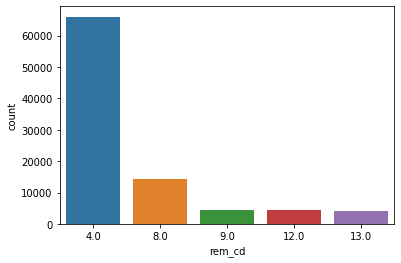

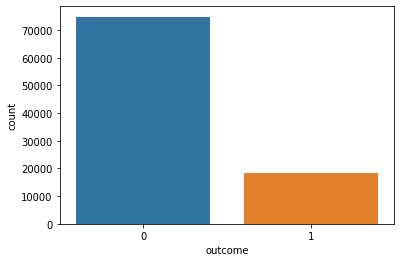

In [26]:
# 0 if transplant
# 1 if deceased
# 2 if removed for other reason
d["outcome"] = d.apply(
    lambda row: 
        1 if row.rem_cd in [8,13] # dies waiting
        else 0, axis=1) # lives

# print distribution plot of rem_cd
sns.countplot(x="rem_cd", data=d)
plt.show()

# print distribution plot of outcomes
sns.countplot(x="outcome", data=d)
plt.show()

In [27]:
# print percentage of each outcome
print(d.outcome.value_counts(normalize=True))

0   0.80266
1   0.19734
Name: outcome, dtype: float64


In [28]:
all_selected = selected_vars + ["outcome"]
d = d[all_selected]
selset = set(selected_vars)
numerical_columns = list(set(numerical_columns) & selset)
categorical_columns = list(set(categorical_columns) & selset)
date_columns = list(set(date_columns) & selset)
drug_columns = list(set(drug_columns) & selset)

print("Number numeric columns:", len(numerical_columns))
print("Number categorical columns:", len(categorical_columns))
print("Number date columns:", len(date_columns))
print("Number drug columns:", len(drug_columns))

Number numeric columns: 8
Number categorical columns: 26
Number date columns: 0
Number drug columns: 0


# Imputation

Let's add "missing value" columns.

In [29]:
# add missing indicator to all columns with missing values
for col in numerical_columns:
    if d[col].isna().any():
        d[col + "_missing"] = d[col].isna().astype(int)

# add missing category for each categorical column
for col in categorical_columns:
    d[col].fillna("missing", inplace=True)

Finally, let's impute the missing values.

In [30]:
# impute numerical columns with mean
d[numerical_columns] = d[numerical_columns].fillna(d[numerical_columns].mean())
# TODO: impute with randomness

# Normalization and encoding

Now, let's normalize numerical values.

In [31]:
from sklearn.preprocessing import StandardScaler

# standardize numerical columns
scaler = StandardScaler()
d[numerical_columns] = scaler.fit_transform(d[numerical_columns])

Let's also encode categorical columns using One-Hot encoding.

In [32]:
d = pd.get_dummies(d, columns=categorical_columns, drop_first=True) # drop redundant column

In [33]:
print("Number columns after one-hot encoding:", len(d.columns))

Number columns after one-hot encoding: 160


# Model training

Useful functions:

In [40]:
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix

def print_evaluation(y_test, y_pred):
    print(classification_report(y_test, y_pred))
    cm = confusion_matrix(y_test, y_pred)
    sns.heatmap(cm, annot=True, fmt='d')
    plt.show()

def print_training_history(history):
    history_dict = history.history
    loss_values = history_dict["loss"]
    val_loss_values = history_dict["val_loss"]
    epochs = range(1, len(loss_values) + 1)
    plt.plot(epochs, loss_values, "bo", label="Training loss")
    plt.plot(epochs, val_loss_values, "b", label="Validation loss")
    plt.title("Training and validation loss")
    plt.xlabel("Epochs")
    plt.ylabel("Loss")
    plt.legend()
    plt.show()

    acc = history_dict["accuracy"]
    val_acc = history_dict["val_accuracy"]
    plt.plot(epochs, acc, "bo", label="Training acc")
    plt.plot(epochs, val_acc, "b", label="Validation acc")
    plt.title("Training and validation accuracy")
    plt.xlabel("Epochs")
    plt.ylabel("Accuracy")
    plt.legend()
    plt.show()

from keras.callbacks import EarlyStopping
early_stopping_monitor = EarlyStopping(patience=5)

In [35]:
# split data into train and test
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(d.drop("outcome", axis=1), d.outcome, test_size=0.2, random_state=1337)

## Simple Logistic Regression Model

              precision    recall  f1-score   support

           0       0.87      0.95      0.91     15018
           1       0.68      0.40      0.50      3628

    accuracy                           0.85     18646
   macro avg       0.77      0.68      0.71     18646
weighted avg       0.83      0.85      0.83     18646



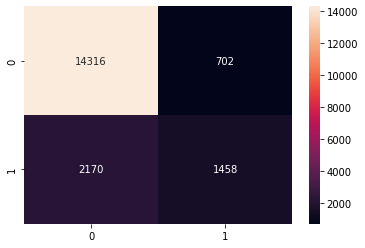

In [151]:
# Simple logistic regression model test
from sklearn.linear_model import LogisticRegression

# train model
model = LogisticRegression(solver="lbfgs", max_iter=1000, n_jobs=-1)
model.fit(X_train, y_train)

y_pred = model.predict(X_test)

print_evaluation(y_test, y_pred)

In [152]:
# print weights ordered by scale
weights = pd.DataFrame({"feature": X_train.columns, "weight": model.coef_[0]})
weights["abs_weight"] = weights.weight.abs()
weights = weights.sort_values("abs_weight", ascending=False)
print(weights)

                         feature   weight  abs_weight
135      work_income_tcr_missing  6.84099     6.84099
133            work_income_tcr_U  2.93247     2.93247
72      academic_level_tcr_996.0  2.58001     2.58001
52   prior_card_surg_tcr_missing -2.28536     2.28536
45               cig_use_missing -2.00455     2.00455
150        func_stat_tcr_missing  1.94941     1.94941
74    academic_level_tcr_missing  1.90521     1.90521
149         func_stat_tcr_2100.0 -1.21365     1.21365
134            work_income_tcr_Y -1.08199     1.08199
71        academic_level_tcr_3.0 -1.01867     1.01867
129                     onvent_Y  0.99507     0.99507
99             thoracic_dgn_1106 -0.87802     0.87802
66               dial_ty_tcr_3.0  0.87109     0.87109
125            thoracic_dgn_1607 -0.84987     0.84987
98             thoracic_dgn_1105  0.82651     0.82651
88             thoracic_dgn_1051  0.80776     0.80776
97             thoracic_dgn_1104  0.80564     0.80564
32             education_mis

## 1*16 Neural Network

In [47]:
# 1*16 neural network
from keras.models import Sequential
from keras.layers import Dense

m16 = Sequential([
    Dense(16, activation="relu", input_shape=(X_train.shape[1],)),
    Dense(1, activation="sigmoid")
])

m16.compile(optimizer="adam", loss="binary_crossentropy", metrics=["accuracy"])

history = m16.fit(X_train, y_train, epochs=100, validation_split=0.2, callbacks=[early_stopping_monitor])

Epoch 1/100
1865/1865 [==============================] - 23s 12ms/step - loss: 0.3901 - accuracy: 0.8215 - val_loss: 0.3537 - val_accuracy: 0.8334
Epoch 2/100
1865/1865 [==============================] - 12s 7ms/step - loss: 0.3427 - accuracy: 0.8412 - val_loss: 0.3473 - val_accuracy: 0.8376
Epoch 3/100
1865/1865 [==============================] - 12s 7ms/step - loss: 0.3375 - accuracy: 0.8429 - val_loss: 0.3432 - val_accuracy: 0.8399
Epoch 4/100
1865/1865 [==============================] - 11s 6ms/step - loss: 0.3339 - accuracy: 0.8452 - val_loss: 0.3410 - val_accuracy: 0.8409
Epoch 5/100
1865/1865 [==============================] - 11s 6ms/step - loss: 0.3327 - accuracy: 0.8453 - val_loss: 0.3402 - val_accuracy: 0.8425
Epoch 6/100
1865/1865 [==============================] - 12s 6ms/step - loss: 0.3307 - accuracy: 0.8459 - val_loss: 0.3405 - val_accuracy: 0.8435
Epoch 7/100
1865/1865 [==============================] - 12s 6ms/step - loss: 0.3298 - accuracy: 0.8471 - val_loss: 0.3390 

583/583 [==============================] - 1s 2ms/step


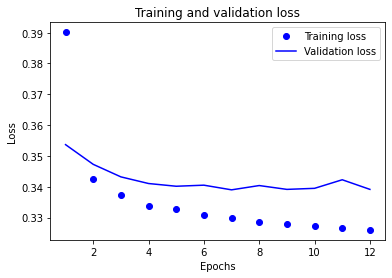

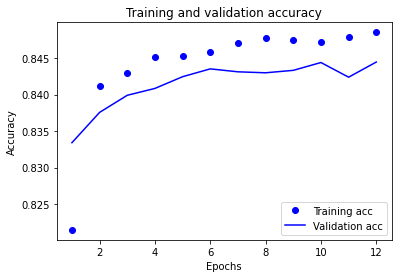

              precision    recall  f1-score   support

           0       0.87      0.95      0.91     15018
           1       0.68      0.40      0.50      3628

    accuracy                           0.85     18646
   macro avg       0.77      0.68      0.71     18646
weighted avg       0.83      0.85      0.83     18646



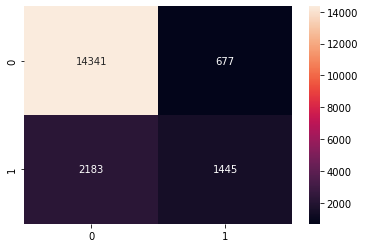

In [49]:
y_pred = np.round(m16.predict(X_test))
print_training_history(history)
print_evaluation(y_test, y_pred)

## 1*32 Neural Network

In [45]:
# 1*32 neural network
from keras.models import Sequential
from keras.layers import Dense

m32 = Sequential([
    Dense(32, activation="relu", input_shape=(X_train.shape[1],)),
    Dense(1, activation="sigmoid")
])

m32.compile(optimizer="adam", loss="binary_crossentropy", metrics=["accuracy"])

history = m32.fit(X_train, y_train, epochs=100, validation_split=0.2, callbacks=[early_stopping_monitor])

Epoch 1/100
1865/1865 [==============================] - 22s 11ms/step - loss: 0.3807 - accuracy: 0.8268 - val_loss: 0.3627 - val_accuracy: 0.8244
Epoch 2/100
1865/1865 [==============================] - 11s 6ms/step - loss: 0.3412 - accuracy: 0.8416 - val_loss: 0.3485 - val_accuracy: 0.8368
Epoch 3/100
1865/1865 [==============================] - 11s 6ms/step - loss: 0.3368 - accuracy: 0.8430 - val_loss: 0.3447 - val_accuracy: 0.8409
Epoch 4/100
1865/1865 [==============================] - 12s 6ms/step - loss: 0.3338 - accuracy: 0.8453 - val_loss: 0.3444 - val_accuracy: 0.8368
Epoch 5/100
1865/1865 [==============================] - 12s 6ms/step - loss: 0.3313 - accuracy: 0.8471 - val_loss: 0.3414 - val_accuracy: 0.8411
Epoch 6/100
1865/1865 [==============================] - 11s 6ms/step - loss: 0.3294 - accuracy: 0.8473 - val_loss: 0.3403 - val_accuracy: 0.8419
Epoch 7/100
1865/1865 [==============================] - 12s 6ms/step - loss: 0.3279 - accuracy: 0.8475 - val_loss: 0.3407 

583/583 [==============================] - 1s 2ms/step


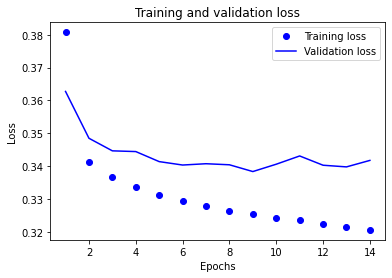

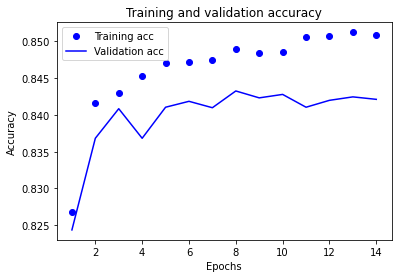

              precision    recall  f1-score   support

           0       0.88      0.94      0.91     15018
           1       0.66      0.45      0.53      3628

    accuracy                           0.85     18646
   macro avg       0.77      0.70      0.72     18646
weighted avg       0.83      0.85      0.84     18646



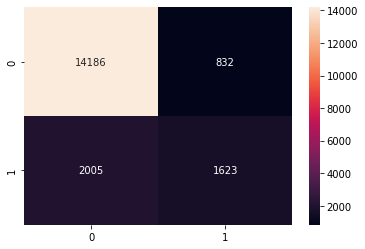

In [46]:
y_pred = np.round(m32.predict(X_test))

print_training_history(history)
print_evaluation(y_test, y_pred)

## 1*64 Neural Network

In [38]:
# 1*64 neural network
from keras.models import Sequential
from keras.layers import Dense, Dropout

m64 = Sequential([
    Dense(64, input_dim=X_train.shape[1], activation="relu"),
    Dropout(0.5),
    Dense(1, activation="sigmoid")
])
m64.compile(loss="binary_crossentropy", metrics=["accuracy"])

history = m64.fit(X_train, y_train, epochs=100, validation_split=0.2, callbacks=[early_stopping_monitor])

Epoch 1/100
1865/1865 [==============================] - 24s 13ms/step - loss: 0.3982 - accuracy: 0.8202 - val_loss: 0.3546 - val_accuracy: 0.8325
Epoch 2/100
1865/1865 [==============================] - 8s 4ms/step - loss: 0.3541 - accuracy: 0.8378 - val_loss: 0.3485 - val_accuracy: 0.8384
Epoch 3/100
1865/1865 [==============================] - 12s 6ms/step - loss: 0.3495 - accuracy: 0.8404 - val_loss: 0.3473 - val_accuracy: 0.8398
Epoch 4/100
1865/1865 [==============================] - 12s 6ms/step - loss: 0.3477 - accuracy: 0.8424 - val_loss: 0.3480 - val_accuracy: 0.8408
Epoch 5/100
1865/1865 [==============================] - 11s 6ms/step - loss: 0.3483 - accuracy: 0.8420 - val_loss: 0.3511 - val_accuracy: 0.8399
Epoch 6/100
1865/1865 [==============================] - 8s 4ms/step - loss: 0.3485 - accuracy: 0.8409 - val_loss: 0.3520 - val_accuracy: 0.8372
Epoch 7/100
1865/1865 [==============================] - 10s 5ms/step - loss: 0.3479 - accuracy: 0.8420 - val_loss: 0.3488 - 

583/583 [==============================] - 2s 3ms/step
              precision    recall  f1-score   support

           0       0.86      0.97      0.91     15018
           1       0.71      0.34      0.46      3628

    accuracy                           0.84     18646
   macro avg       0.78      0.65      0.68     18646
weighted avg       0.83      0.84      0.82     18646



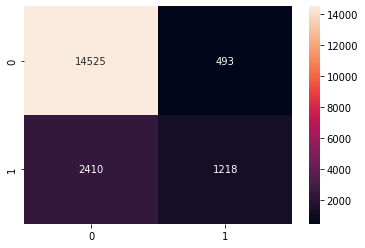

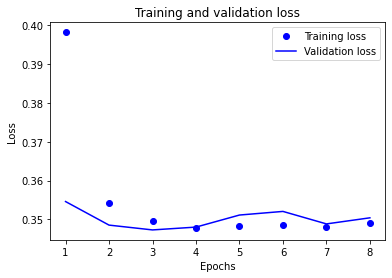

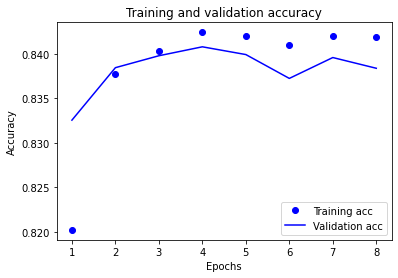

In [41]:
y_pred = np.round(m64.predict(X_test))

print_evaluation(y_test, y_pred)
print_training_history(history)

## 1 * 128 neural network

In [42]:
m128 = Sequential([
    Dense(128, input_dim=X_train.shape[1], activation="relu"),
    Dropout(0.5),
    Dense(1, activation="sigmoid")
])
m128.compile(loss="binary_crossentropy", metrics=["accuracy"])

history = m128.fit(X_train, y_train, epochs=100, validation_split=0.2, callbacks=[early_stopping_monitor])

Epoch 1/100
1865/1865 [==============================] - 21s 11ms/step - loss: 0.3850 - accuracy: 0.8254 - val_loss: 0.3503 - val_accuracy: 0.8367
Epoch 2/100
1865/1865 [==============================] - 14s 7ms/step - loss: 0.3518 - accuracy: 0.8395 - val_loss: 0.3467 - val_accuracy: 0.8390
Epoch 3/100
1865/1865 [==============================] - 14s 7ms/step - loss: 0.3474 - accuracy: 0.8415 - val_loss: 0.3476 - val_accuracy: 0.8399
Epoch 4/100
1865/1865 [==============================] - 14s 7ms/step - loss: 0.3471 - accuracy: 0.8430 - val_loss: 0.3480 - val_accuracy: 0.8386
Epoch 5/100
1865/1865 [==============================] - 13s 7ms/step - loss: 0.3457 - accuracy: 0.8423 - val_loss: 0.3474 - val_accuracy: 0.8396
Epoch 6/100
1865/1865 [==============================] - 13s 7ms/step - loss: 0.3447 - accuracy: 0.8431 - val_loss: 0.3462 - val_accuracy: 0.8405
Epoch 7/100
1865/1865 [==============================] - 13s 7ms/step - loss: 0.3448 - accuracy: 0.8433 - val_loss: 0.3485 

583/583 [==============================] - 2s 3ms/step


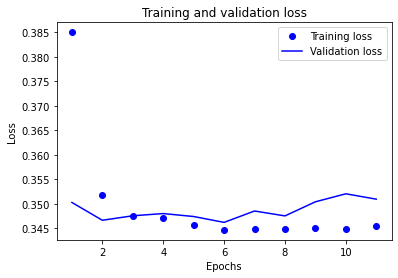

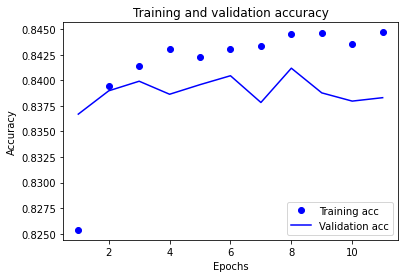

              precision    recall  f1-score   support

           0       0.86      0.97      0.91     15018
           1       0.71      0.34      0.46      3628

    accuracy                           0.84     18646
   macro avg       0.78      0.65      0.68     18646
weighted avg       0.83      0.84      0.82     18646



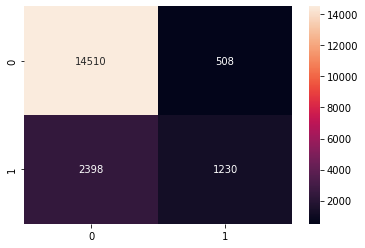

In [43]:
y_pred = np.round(m128.predict(X_test))

print_training_history(history)
print_evaluation(y_test, y_pred)

## 2 * 60 Neural network

In [114]:
# 2 * 60 neural network
from keras.models import Sequential
from keras.layers import Dense, Dropout

m260 = Sequential([
    Dense(60, input_dim=X_train.shape[1], activation="relu"),
    Dropout(0.5),
    Dense(60, activation="relu"),
    Dropout(0.5),
    Dense(1, activation="sigmoid")
])

m260.compile(loss="binary_crossentropy", optimizer="rmsprop", metrics=["accuracy"])

history = m260.fit(X_train, y_train, epochs=100, validation_split=0.2, callbacks=[early_stopping_monitor])

2023-05-12 09:38:03.140825: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-05-12 09:38:03.597746: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2023-05-12 09:38:03.597792: I tensorflow/compiler/xla/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.
2023-05-12 09:38:05.691111: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer.so.7'; dlerror: libnvinfer.so.7: cannot open shared object file: No such file or directory
2023-

Epoch 1/100
1865/1865 [==============================] - 21s 11ms/step - loss: 0.3945 - accuracy: 0.8207 - val_loss: 0.3543 - val_accuracy: 0.8337
Epoch 2/100
1865/1865 [==============================] - 10s 5ms/step - loss: 0.3564 - accuracy: 0.8365 - val_loss: 0.3491 - val_accuracy: 0.8360
Epoch 3/100
1865/1865 [==============================] - 8s 4ms/step - loss: 0.3528 - accuracy: 0.8393 - val_loss: 0.3479 - val_accuracy: 0.8380
Epoch 4/100
1865/1865 [==============================] - 10s 6ms/step - loss: 0.3511 - accuracy: 0.8400 - val_loss: 0.3466 - val_accuracy: 0.8388
Epoch 5/100
1865/1865 [==============================] - 10s 5ms/step - loss: 0.3490 - accuracy: 0.8405 - val_loss: 0.3487 - val_accuracy: 0.8351
Epoch 6/100
1865/1865 [==============================] - 11s 6ms/step - loss: 0.3487 - accuracy: 0.8409 - val_loss: 0.3472 - val_accuracy: 0.8392
Epoch 7/100
1865/1865 [==============================] - 10s 5ms/step - loss: 0.3493 - accuracy: 0.8412 - val_loss: 0.3472 -

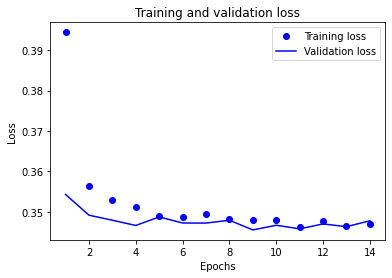

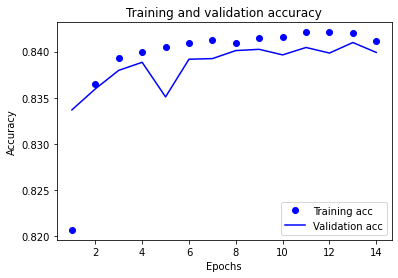

In [115]:
history_dict = history.history
loss_values = history_dict["loss"]
val_loss_values = history_dict["val_loss"]
epochs = range(1, len(loss_values) + 1)
plt.plot(epochs, loss_values, "bo", label="Training loss")
plt.plot(epochs, val_loss_values, "b", label="Validation loss")
plt.title("Training and validation loss")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend()
plt.show()

acc = history_dict["accuracy"]
val_acc = history_dict["val_accuracy"]
plt.plot(epochs, acc, "bo", label="Training acc")
plt.plot(epochs, val_acc, "b", label="Validation acc")
plt.title("Training and validation accuracy")
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.legend()
plt.show()

583/583 [==============================] - 2s 4ms/step
              precision    recall  f1-score   support

           0       0.86      0.97      0.91     15018
           1       0.72      0.35      0.47      3628

    accuracy                           0.85     18646
   macro avg       0.79      0.66      0.69     18646
weighted avg       0.83      0.85      0.82     18646



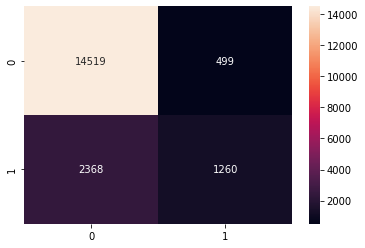

In [116]:
y_pred = np.round(m260.predict(X_test))

# classificaiton report
from sklearn.metrics import classification_report
print(classification_report(y_test, y_pred))

# plot confusion matrix
from sklearn.metrics import confusion_matrix
import seaborn as sns
cm = confusion_matrix(y_test, y_pred)
sns.heatmap(cm, annot=True, fmt="d")
plt.show()

# 2*100 Neural Network

In [94]:
# 2 * 100 neural network
from keras.models import Sequential
from keras.layers import Dense, Dropout
from keras.callbacks import EarlyStopping

m200 = Sequential([
    Dense(100, input_dim=X_train.shape[1], activation="relu"),
    Dropout(0.5),
    Dense(100, activation="relu"),
    Dropout(0.5),
    Dense(1, activation="sigmoid")
])

m200.compile(loss="binary_crossentropy", optimizer="rmsprop", metrics=["accuracy"])

history = m200.fit(X_train, y_train, epochs=100, validation_split=0.2, callbacks=[early_stopping_monitor])

Epoch 1/100
1318/1318 [==============================] - 7s 5ms/step - loss: 0.4394 - accuracy: 0.7814 - val_loss: 0.3833 - val_accuracy: 0.7995
Epoch 2/100
1318/1318 [==============================] - 3s 2ms/step - loss: 0.3908 - accuracy: 0.8033 - val_loss: 0.3805 - val_accuracy: 0.7995
Epoch 3/100
1318/1318 [==============================] - 3s 2ms/step - loss: 0.3854 - accuracy: 0.8089 - val_loss: 0.3753 - val_accuracy: 0.8076
Epoch 4/100
1318/1318 [==============================] - 3s 2ms/step - loss: 0.3827 - accuracy: 0.8084 - val_loss: 0.3757 - val_accuracy: 0.8048
Epoch 5/100
1318/1318 [==============================] - 3s 2ms/step - loss: 0.3809 - accuracy: 0.8111 - val_loss: 0.3752 - val_accuracy: 0.8060
Epoch 6/100
1318/1318 [==============================] - 3s 3ms/step - loss: 0.3815 - accuracy: 0.8102 - val_loss: 0.3745 - val_accuracy: 0.8073
Epoch 7/100
1318/1318 [==============================] - 3s 3ms/step - loss: 0.3790 - accuracy: 0.8115 - val_loss: 0.3744 - val_ac

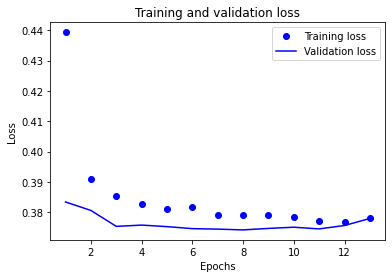

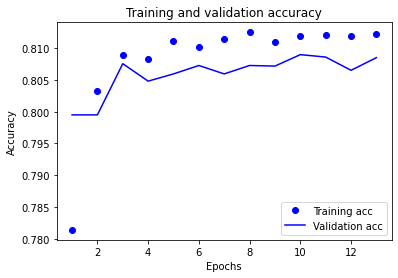

In [95]:
history_dict = history.history
loss_values = history_dict["loss"]
val_loss_values = history_dict["val_loss"]
epochs = range(1, len(loss_values) + 1)
plt.plot(epochs, loss_values, "bo", label="Training loss")
plt.plot(epochs, val_loss_values, "b", label="Validation loss")
plt.title("Training and validation loss")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend()
plt.show()

acc = history_dict["accuracy"]
val_acc = history_dict["val_accuracy"]
plt.plot(epochs, acc, "bo", label="Training acc")
plt.plot(epochs, val_acc, "b", label="Validation acc")
plt.title("Training and validation accuracy")
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.legend()
plt.show()

412/412 [==============================] - 0s 1ms/step
              precision    recall  f1-score   support

           0       0.84      0.94      0.89     10077
           1       0.68      0.40      0.50      3097

    accuracy                           0.81     13174
   macro avg       0.76      0.67      0.70     13174
weighted avg       0.80      0.81      0.80     13174



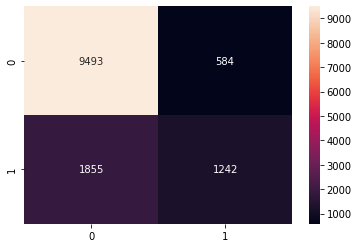

In [96]:
y_pred = np.round(m200.predict(X_test))

# classificaiton report
from sklearn.metrics import classification_report
print(classification_report(y_test, y_pred))

# plot confusion matrix
from sklearn.metrics import confusion_matrix
import seaborn as sns
cm = confusion_matrix(y_test, y_pred)
sns.heatmap(cm, annot=True, fmt="d")
plt.show()

# Forward Selection

In [346]:
# Perform forward feature selection
from sklearn.linear_model import LogisticRegression
from sklearn.feature_selection import SequentialFeatureSelector

lr = LogisticRegression(solver="lbfgs", max_iter=1000)

# forward feature selection
sfs = SequentialFeatureSelector(lr, n_features_to_select=50, direction="forward", scoring="f1_macro", n_jobs=-1)
sfs.fit(pd.concat([X_train, X_test]), pd.concat([y_train, y_test]))

# print selected features
print("Selected features:", X_train.columns[sfs.get_support()])


Selected features: Index(['most_rcnt_creat', 'tot_serum_album', 'most_rcnt_creat_missing',
       'init_wgt_kg_calc_missing', 'cig_use_missing',
       'work_income_tcr_missing', 'rvad_at_listing_missing',
       'lvad_at_listing_missing', 'cereb_vasc_N', 'cereb_vasc_U',
       'cereb_vasc_Y', 'prior_card_surg_tcr_N', 'prior_card_surg_tcr_U',
       'prior_card_surg_tcr_Y', 'init_stat_2110.0', 'init_stat_2120.0',
       'init_stat_2140.0', 'init_stat_2150.0', 'dial_ty_tcr_3.0',
       'dial_ty_tcr_998.0', 'dial_ty_tcr_999.0', 'malig_tcr_N', 'malig_tcr_U',
       'malig_tcr_Y', 'thoracic_dgn_1201', 'thoracic_dgn_1202',
       'work_income_tcr_N', 'work_income_tcr_U', 'work_income_tcr_Y',
       'diab_998.0', 'func_stat_tcr_3.0', 'func_stat_tcr_996.0',
       'func_stat_tcr_2010.0', 'func_stat_tcr_2100.0',
       'academic_level_tcr_1.0', 'academic_level_tcr_2.0',
       'academic_level_tcr_3.0', 'academic_level_tcr_996.0',
       'academic_level_tcr_998.0', 'education_2.0', 'education_4

In [ ]:
import dill
dill.dump_session("post_forward_selection.db")
#